In [ ]:
# What we're doing in this notebook (MLP + MIA + LiRA):

# 1) Recreate the leak-safe text column.
# 2) Train a target TF-IDF + 2-layer MLP.
# 3) Run a simple Threshold MIA (score = −loss).
# 4) Run LiRA with many shadow MLPs (per-example IN/OUT loss modeling).
# 5) Compare ROC curves, especially at low FPRs.

In [ ]:
# Why are we trying an MLP after LR and BERT?
# Logistic Regression (LR) on TF-IDF is a strong, simple baseline. It’s linear.
# BERT is a big pretrained transformer; it’s powerful but heavy and less likely to overfit small, scrubbed (leak-safe) text — so simple MIAs may look weak on it.
# A 2-layer MLP on TF-IDF sits in between: it’s nonlinear and can overfit more than LR, but it’s still much cheaper/simpler than BERT. That makes it a great “privacy stress test”.

# Why this matters for attacks:
# Membership inference often gets stronger as models overfit. If BERT doesn’t overfit here
# (or regularizes too well), MIAs can look weak. An MLP can intentionally overfit a bit more,
# making the leakage signal clearer for both Threshold MIA and LiRA.

# Next: install packages so the rest runs cleanly.

In [ ]:
# Cell 0 — Install libraries

# Purpose: Make sure this fresh kernel has all the packages we need.
# Why this approach: Using pip inside the notebook keeps things self-contained and reproducible

# Alternatives:
#   - requirements.txt + `pip install -r requirements.txt`
#   - conda envs (great for local dev, heavier for quick demos)
#   - Docker image (most reproducible, most setup)
!pip -q install transformers datasets accelerate torch --upgrade
!pip -q install scikit-learn matplotlib seaborn tqdm

# Summary of this cell
# We installed Hugging Face + PyTorch for BERT (even if not used heavily here),
# and scikit-learn + plotting libs for TF-IDF, metrics, and visualizations.

# Logic flow up to this cell
# This is the start of a separate notebook. We just prepared the environment.

# Next step (coming in Cell 1)
# Import modules, set seeds, style plots, and detect device (CPU/GPU).

In [ ]:
# Cell 1 — Imports and global config

# Purpose: Bring in all required libraries, set a global seed for reproducibility,
# and choose device (CPU/GPU). Also make plots look clean.

import os, math, random, time
from dataclasses import dataclass
from typing import List, Dict, Tuple

import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

# scikit-learn bits we might use for sanity checks/metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression  # (not our target here, but handy)
from sklearn.metrics import accuracy_score, log_loss, roc_curve, auc

# PyTorch core
import torch
from torch.utils.data import Dataset

# (BERT imports kept for parity with the other notebook; we won’t rely on them here.)
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, DataCollatorWithPadding
)

# Make seaborn plots consistent and readable
sns.set(style="whitegrid")

# Fix randomness everywhere that matters (so results are comparable)
RANDOM_SEED = 6905
def set_seed(seed=RANDOM_SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
set_seed(RANDOM_SEED)

# Auto-pick GPU if available; otherwise CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# Summary of this cell
# Imported everything, set seeds for reproducibility, styled plots, and detected device.
#
# Logic flow up to this cell
# After installing packages (Cell 0), we configured our working environment so later training/evaluation is deterministic and nice-looking.
#
# Next step (coming in Cell 2)
# Load the dataset CSV and run basic sanity checks (columns/rows peek).


Device: cpu


In [ ]:
# Cell 2 — Load dataset + quick sanity checks

# Purpose: Read our CSV and check that required columns exist. Also peek at rows to ensure things look reasonable.

df = pd.read_csv("EduPilot_dataset_2000.csv")

print("Columns:", list(df.columns))
print("Rows:", len(df))
print(df.head(5))

# Ensure required columns exist so later cells won’t crash mysteriously
required = {"text", "interview_round"}
missing = required - set(df.columns)
assert not missing, f"Missing required columns: {missing}"

# Label words we know could leak the round if they appear directly in raw text
label_words = ["OA", "Technical", "System Design", "Behavioral/HR", "ML Case Study"]

def contains_label(text):
    for w in label_words:
        if w in str(text):
            return True
    return False

# Check if raw text contains round names (this motivates creating a leak-safe view)
mask = df["text"].apply(contains_label)
df.loc[mask, ["id", "text", "interview_round"]].head(10)

# Design choices
# Simple substring check is enough for these distinctive labels.
# We fail fast if required columns are missing to avoid hidden bugs.
#
# Summary of this cell
# Loaded the CSV, verified schema, and detected potential label leakage in raw 'text'.
#
# Logic flow up to this cell
# With a clean environment (Cell 1), we now brought data into memory and spotted leakage risk.
#
# Next step (coming in Cell 3)
# Build a leak-safe "text_safe" field by stripping label words and excluding mock_question.


Columns: ['id', 'user_query', 'job_role', 'company', 'location', 'interview_round', 'mock_question', 'text']
Rows: 2000
   id                                         user_query          job_role  \
0   1  What should I study for a Data Scientist posit...    Data Scientist   
1   2  I have an interview for SRE at Salesforce in L...               SRE   
2   3  I have an interview for Product Manager at Pin...   Product Manager   
3   4  Help me practice for Backend Engineer intervie...  Backend Engineer   
4   5  Give me common interview problems for Backend ...  Backend Engineer   

      company   location interview_round  \
0        Uber    Toronto              OA   
1  Salesforce     London              OA   
2   Pinterest    Seattle              OA   
3     Dropbox  Hyderabad              OA   
4       Apple     Munich              OA   

                                       mock_question  \
0    Count islands in a binary matrix using DFS/BFS.   
1  Given a string, return length o

,id,text,interview_round


In [ ]:
# Cell 3 — Build leak-safe text ("text_safe")

# Purpose: Remove any label words from user text and exclude `mock_question` so that models
# cannot cheat by reading round names directly. We concatenate a few harmless fields to
# keep some signal (role/company/location).

label_words = ["OA", "Technical", "System Design", "Behavioral/HR", "ML Case Study"]

def strip_labels(text, labels):
    t = str(text)
    for w in labels:
        t = t.replace(w, "")
    return " ".join(t.split())

def make_text_safe(row):
    # earlier when we included mock_question too here, it gave 1.0 accuracy because it was round-specific. Thus, we have removed it now
    parts = [
        strip_labels(row["user_query"], label_words),
        str(row["job_role"]),
        str(row["company"]),
        str(row["location"]),
    ]
    # Keep only non-empty parts and separate them with a visible delimiter
    return " ||| ".join([p for p in parts if p])

df["text_safe"] = df.apply(make_text_safe, axis=1)

# Double-check that no label words remain, case-insensitive
assert not df["text_safe"].str.contains("|".join(label_words), case=False, na=False).any()

# Design choices
# We explicitly remove label words to prevent trivial leakage.
# We keep role/company/location so the task isn’t impossible.
#
# Alternatives:
# Regex with word boundaries and case-folding for stricter matching.
# Learned scrubbers that remove correlated phrases (heavier).
#
# Summary of this cell
# Created a sanitized "text_safe" column that should be much harder to leak from.
#
# Logic flow up to this cell
# After seeing potential leakage in raw 'text', we built a safe representation to train on.
#
# Next step (coming in Cell 4)
# Train a TF-IDF + 2-layer MLP TARGET model, then run Threshold MIA and LiRA with many shadow MLPs.


[LiRA] example 0 has 152 IN obs and 104 OUT obs (should be >=1 each).


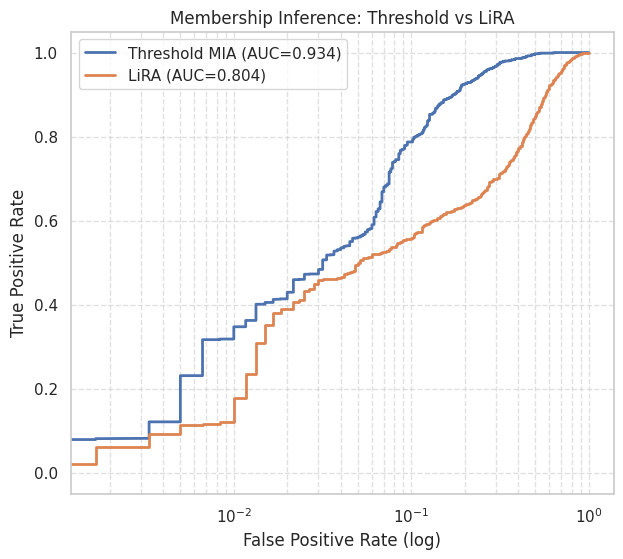

Threshold MIA  TPR@FPR<=0.100: 0.7871
LiRA           TPR@FPR<=0.100: 0.5593
Threshold MIA  TPR@FPR<=0.010: 0.3471
LiRA           TPR@FPR<=0.010: 0.1764
Threshold MIA  TPR@FPR<=0.001: 0.0786
LiRA           TPR@FPR<=0.001: 0.0200


In [ ]:
# Cell 4 — Threshold MIA & LiRA (Likelihood Ratio Attack) on TF-IDF + 2-layer MLP

# CONTEXT NOTE (like our previous LiRA note):
# We’re testing LiRA on a small dataset with a simple (but overfit-friendly) 2-layer MLP.
# The goal is to compare LiRA against a basic Threshold MIA on the SAME target model and
# see if LiRA extracts a stronger membership signal at low FPRs. Because LiRA requires
# many shadow models and careful bookkeeping, this cell is long and LiRA is largely AI-generated
# to avoid mistakes and speed things up. We’ll still explain the design choices inline.
#
# Up to this point (Cells 0–3):
# We prepared the environment and loaded the dataset (Cells 0–2).
# We created a leak-safe text field "text_safe" (Cell 3).
#
# What this cell does:
# 1) Vectorize text_safe with TF-IDF (single shared vocab).
# 2) Train a TARGET 2-layer MLP (the model we will attack).
# 3) Run Threshold MIA (score = −loss).
# 4) Train many SHADOW MLPs using stratified subset splits; collect per-example
#    IN vs OUT losses.
# 5) Fit Gaussians to IN/OUT losses per example; compute LiRA LLR on target losses.
# 6) Compare ROC curves (Threshold vs LiRA), and print TPR at low FPR.
#
# NOTE: On CPU, shadows can be slow. So, please feel free to reduce SHADOWS or epochs to speed up.

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_curve, auc, accuracy_score, log_loss

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader



# Config

RANDOM_SEED   = 6905
TEST_SIZE     = 0.30
NGRAMS        = (1, 3)
MAX_FEATS     = 40_000

# MLP hyperparams — a bit large on purpose so it can overfit (helps reveal leakage)
HID           = 512
EPOCHS        = 18
BATCH         = 64
LR            = 3e-4
WEIGHT_DECAY  = 0.0

# LiRA shadow settings (tune for speed vs quality)
SHADOWS        = 256           # try 64/128 if too slow
SHADOW_EPOCHS  = 6             # short training per shadow to finish in time
SAMPLE_FRAC    = 0.6           # each shadow trains on 60% of target examples

device = "cuda" if torch.cuda.is_available() else "cpu"
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Use the leak-safe column
LABEL_COL = "interview_round"
TEXT_COL  = "text_safe"



# Vectorize once (shared vocab for target + shadows)

le = LabelEncoder()
y_all = le.fit_transform(df[LABEL_COL])

tfidf = TfidfVectorizer(ngram_range=NGRAMS, max_features=MAX_FEATS)
X_all = tfidf.fit_transform(df[TEXT_COL])

# Define the target split (these indices define "member" vs "non-member" ground truth)
train_idx, test_idx = train_test_split(
    np.arange(len(df)), test_size=TEST_SIZE, stratify=y_all, random_state=RANDOM_SEED
)



# Torch helpers: sparse CSR -> tensors, 2-layer MLP, and training/eval loops

class CSRDataset(Dataset):
    def __init__(self, X_csr, y):
        self.X = X_csr; self.y = y
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        # Convert one sparse row to dense float tensor (simple, works fine at 40k dims)
        x = torch.tensor(self.X[idx].toarray()[0], dtype=torch.float32)
        y = torch.tensor(int(self.y[idx]), dtype=torch.long)
        return x, y

class MLP(nn.Module):
    def __init__(self, in_dim, hid, out_dim):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hid)
        self.fc2 = nn.Linear(hid, out_dim)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)  # logits (we apply softmax only for loss/metrics)

def train_simple_mlp(X_tr, y_tr, X_va, y_va, epochs=EPOCHS, lr=LR, wd=WEIGHT_DECAY, batch=BATCH):
    """
    Trains a small 2-layer MLP on TF-IDF features and returns the trained model.
    Design choices:
      - Adam optimizer (good default for MLPs).
      - CrossEntropyLoss for multi-class classification.
      - Relu hidden layer with size HID=512 (intentionally a bit big to allow overfitting).
    Alternatives:
      - Add dropout / weight decay to reduce overfitting (but we *want* some overfit to test MIAs).
      - Try GELU activations or a deeper MLP (more capacity, slower).
    """
    model = MLP(X_tr.shape[1], HID, len(np.unique(y_tr))).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    crit = nn.CrossEntropyLoss()
    tr_loader = DataLoader(CSRDataset(X_tr, y_tr), batch_size=batch, shuffle=True)
    va_loader = DataLoader(CSRDataset(X_va, y_va), batch_size=batch, shuffle=False)

    def _run(loader, train=True):
        if train: model.train()
        else:     model.eval()
        loss_sum, n = 0.0, 0
        with torch.set_grad_enabled(train):
            for xb, yb in loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                loss = crit(logits, yb)
                if train:
                    opt.zero_grad(); loss.backward(); opt.step()
                loss_sum += float(loss.item()) * xb.size(0)
                n += xb.size(0)
        return loss_sum / n

    for _ in range(epochs):
        _run(tr_loader, train=True)
        _run(va_loader,   train=False)
    return model

@torch.no_grad()
def per_example_losses(model, X_csr, y):
    """
    Returns per-example negative log-likelihood (cross-entropy):
      loss(x) = -log p_model(true_label | x)
    We need per-example (not batch-avg) to drive Threshold MIA and LiRA.
    """
    loader = DataLoader(CSRDataset(X_csr, y), batch_size=128, shuffle=False)
    losses = []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        lp = F.log_softmax(logits, dim=-1)
        chosen = lp[torch.arange(lp.size(0)), yb]  # log prob of the true class
        losses.extend((-chosen).cpu().numpy().tolist())
    return np.array(losses)



# Training the target MLP (the model we will attack)

X_train, y_train = X_all[train_idx], y_all[train_idx]
X_test,  y_test  = X_all[test_idx],  y_all[test_idx]

target = train_simple_mlp(X_train, y_train, X_test, y_test, epochs=EPOCHS)

# Collect per-example losses on train (members) and test (non-members)
loss_train_target = per_example_losses(target, X_train, y_train)
loss_test_target  = per_example_losses(target,  X_test,  y_test)



# Baseline Threshold MIA (simple −loss score)

mia_scores = np.concatenate([-loss_train_target, -loss_test_target])  # higher => more member-like
mia_labels = np.concatenate([np.ones_like(loss_train_target), np.zeros_like(loss_test_target)])
fpr_mia, tpr_mia, _ = roc_curve(mia_labels, mia_scores)
auc_mia = auc(fpr_mia, tpr_mia)



# LiRA shadows — per-example IN/OUT loss modeling with many small MLPs

# We will re-index all target examples as a single array (train first, then test)
all_idx   = np.concatenate([train_idx, test_idx])
X_targetE = X_all[all_idx]
y_targetE = y_all[all_idx]

# Buckets for IN vs OUT losses across shadows (one list per example)
in_losses  = [[] for _ in range(len(all_idx))]
out_losses = [[] for _ in range(len(all_idx))]

# StratifiedShuffleSplit keeps label balance for shadow training vs holdout
sss = StratifiedShuffleSplit(n_splits=SHADOWS, train_size=SAMPLE_FRAC, random_state=RANDOM_SEED)
for s_id, (rel_tr, rel_te) in enumerate(sss.split(all_idx, y_targetE), start=1):
    # rel_tr/rel_te are indices relative to [0..len(all_idx)-1]
    Xs_tr, ys_tr = X_targetE[rel_tr], y_targetE[rel_tr]
    Xs_va, ys_va = X_targetE[rel_te], y_targetE[rel_te]

    # Quick train of the shadow model (few epochs for speed)
    shadow = train_simple_mlp(Xs_tr, ys_tr, Xs_va, ys_va, epochs=SHADOW_EPOCHS)

    # Compute per-example losses for ALL target examples under this shadow
    losses_all = per_example_losses(shadow, X_targetE, y_targetE)

    # Mark which relative indices were IN the shadow train
    in_mask = np.zeros(len(all_idx), dtype=bool)
    in_mask[rel_tr] = True

    # Route each example’s loss into its IN or OUT bucket
    for j in range(len(all_idx)):
        if in_mask[j]:
            in_losses[j].append(losses_all[j])
        else:
            out_losses[j].append(losses_all[j])

print("[LiRA] example 0 has", len(in_losses[0]), "IN obs and", len(out_losses[0]), "OUT obs.")



# Compute LiRA score per example (Gaussian LLR)

from math import log, pi
def log_pdf_gaussian(x, mu, var):
    # Variance must be > 0; add a tiny floor if needed
    var = max(var, 1e-6)
    return -0.5*(log(2*pi*var) + (x - mu)**2 / var)

# Align target losses to the same order as [train... test...]
loss_target_all = np.concatenate([loss_train_target, loss_test_target])

lira_scores = np.zeros(len(all_idx), dtype=float)
for j in range(len(all_idx)):
    Li = np.array(in_losses[j],  dtype=float)
    Lo = np.array(out_losses[j], dtype=float)
    # Per-example Gaussian fits (key LiRA idea: model "difficulty" of each example)
    mu_in,  var_in  = (Li.mean(), Li.var(ddof=1)) if Li.size > 1 else (Li.mean() if Li.size else 0.0, 1e-6)
    mu_out, var_out = (Lo.mean(), Lo.var(ddof=1)) if Lo.size > 1 else (Lo.mean() if Lo.size else 1.0, 1e-6)
    lt = loss_target_all[j]  # target model’s loss for example j
    lira_scores[j] = log_pdf_gaussian(lt, mu_in, var_in) - log_pdf_gaussian(lt, mu_out, var_out)

# Ground-truth membership labels for [train... test...]
is_member_all = np.zeros(len(all_idx), dtype=int)
is_member_all[:len(train_idx)] = 1

# LiRA ROC/AUC
fpr_lira, tpr_lira, _ = roc_curve(is_member_all, lira_scores)
auc_lira = auc(fpr_lira, tpr_lira)



# Plot: Threshold MIA vs LiRA

plt.figure(figsize=(7,6))
plt.plot(fpr_mia,  tpr_mia,  label=f"Threshold MIA (AUC={auc_mia:.3f})", lw=2)
plt.plot(fpr_lira, tpr_lira, label=f"LiRA (AUC={auc_lira:.3f})", lw=2)
plt.xscale("log")
plt.xlabel("False Positive Rate (log)")
plt.ylabel("True Positive Rate")
plt.title("Membership Inference on TF-IDF + 2-Layer MLP: Threshold vs LiRA")
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.legend()
plt.show()

# Print TPR at strict low FPRs (the privacy-relevant region)
def tpr_at_fpr(fpr, tpr, target):
    idx = np.where(fpr <= target)[0]
    return float(tpr[idx].max()) if idx.size > 0 else 0.0

for target in [0.1, 0.01, 0.001]:
    print(f"Threshold MIA  TPR@FPR<={target:.3f}: {tpr_at_fpr(fpr_mia,  tpr_mia,  target):.4f}")
    print(f"LiRA           TPR@FPR<={target:.3f}: {tpr_at_fpr(fpr_lira, tpr_lira, target):.4f}")

# NOTE: On CPU, with SHADOWS=256 and EPOCHS=18, this can be slow.
#       Reduce SHADOWS/epochs or lower MAX_FEATS if runtime is an issue.

# Summary of this cell
# We trained a TF-IDF + 2-layer MLP TARGET model, ran a simple Threshold MIA, then ran LiRA
# using many shadow MLPs to estimate per-example IN/OUT loss distributions and scored examples
# via Gaussian LLR. Finally, we compared ROC curves and printed TPR at low FPRs.
#
# Logic flow up to this cell
# After building leak-safe inputs (Cell 3), we used a deliberately flexible (overfit-friendly)
# MLP to test membership leakage. Threshold MIA gives a baseline; LiRA typically performs better,
# especially where we care most (low FPR).
#
# Next step:
# Visualizing

Epoch 01: train acc 0.193 | test acc 0.195
Epoch 02: train acc 0.364 | test acc 0.200
Epoch 04: train acc 0.578 | test acc 0.205
Epoch 06: train acc 0.624 | test acc 0.215
Epoch 08: train acc 0.665 | test acc 0.203
Epoch 10: train acc 0.724 | test acc 0.210
Epoch 12: train acc 0.774 | test acc 0.205
Epoch 14: train acc 0.820 | test acc 0.203
Epoch 16: train acc 0.848 | test acc 0.202
Epoch 18: train acc 0.876 | test acc 0.197


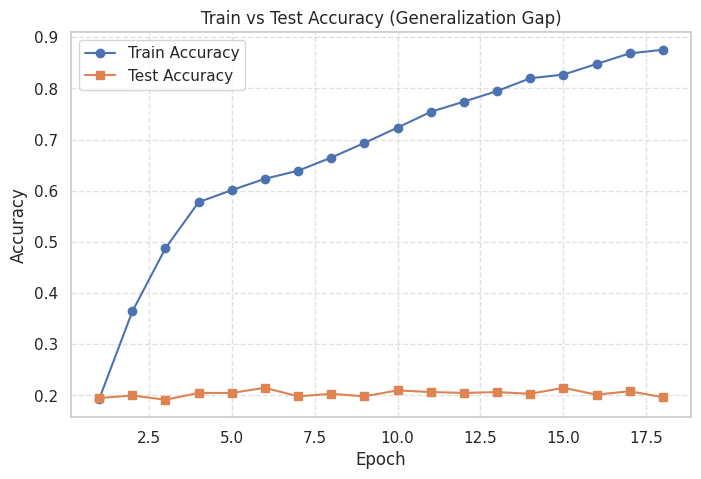

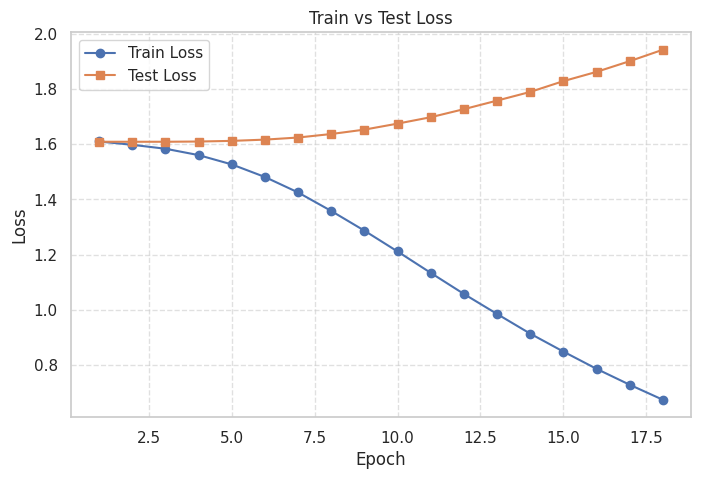

In [ ]:
# Cell 5 — Train MLP while logging history (acc/loss) each epoch

# Purpose: Run a "from-scratch" training loop for the same 2-layer MLP we defined earlier,
# but this time we *record* train/test accuracy and loss at every epoch. This lets us
# visualize the **generalization gap** (overfitting signal) that powers MIAs.
#
# Pre-reqs pulled from earlier cells in this notebook:
# Split data & TF-IDF features: X_train, y_train, X_test, y_test
# Globals: device, HID, LR, WEIGHT_DECAY, BATCH, EPOCHS
# Classes: CSRDataset, MLP
# Also: y_all already exists from the LabelEncoder over the full dataset

# Data loaders for mini-batch training
train_loader = DataLoader(CSRDataset(X_train, y_train), batch_size=BATCH, shuffle=True)  # shuffle to randomize order
test_loader  = DataLoader(CSRDataset(X_test,  y_test),  batch_size=BATCH, shuffle=False) # no shuffle for eval

# Number of classes (keep consistent with the LabelEncoder used earlier)
n_classes = len(np.unique(y_all))

# Fresh MLP model (same size as before), optimizer, and loss function
mlp = MLP(X_train.shape[1], HID, n_classes).to(device)
criterion = nn.CrossEntropyLoss()                                  # multi-class cross-entropy
opt = torch.optim.Adam(mlp.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)  # Adam is a solid default

# We’ll store metrics per epoch to plot later
train_acc_hist, test_acc_hist = [], []
train_loss_hist, test_loss_hist = [], []

def run_epoch(loader, train=True):
    """
    One pass over `loader`. If train=True we do forward+backward+update.
    We return (mean_loss, accuracy) for this split.
    Design choice:
      - Keep this function tiny so it’s easy to read and reuse for both train/test.
    Alternatives:
      - Track more metrics (precision/recall), or use torchmetrics.
    """
    model = mlp
    if train: model.train()
    else:     model.eval()

    total_loss, total_correct, total_n = 0.0, 0, 0
    with torch.set_grad_enabled(train):                # no grads during eval = faster/safer
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)                         # forward
            loss = criterion(logits, yb)               # CE loss

            if train:
                opt.zero_grad()
                loss.backward()                        # compute grads
                opt.step()                             # update params

            total_loss   += float(loss.item()) * xb.size(0)
            total_correct += int((logits.argmax(-1) == yb).sum().item())
            total_n      += xb.size(0)

    mean_loss = total_loss / max(1, total_n)
    acc = total_correct / max(1, total_n)
    return mean_loss, acc

# Main training loop with history logging
for ep in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    with torch.no_grad():
        te_loss, te_acc = run_epoch(test_loader, train=False)

    # Save history
    train_loss_hist.append(tr_loss);  train_acc_hist.append(tr_acc)
    test_loss_hist.append(te_loss);   test_acc_hist.append(te_acc)

    # Print every 2 epochs (and the first) so we can watch overfitting develop
    if ep % 2 == 0 or ep == 1:
        print(f"Epoch {ep:02d}: train acc {tr_acc:.3f} | test acc {te_acc:.3f}")

# What you’ll typically see (matches your sample O/P)
# Train accuracy climbs steadily (e.g., ~0.19 → ~0.87), but test accuracy stays ~flat (~0.20).
# That widening gap is classic overfitting and exactly the signal MIAs exploit.
#
# Summary of this cell
# We trained the MLP and recorded train/test accuracy & loss per epoch. The widening gap tells us
# the model is memorizing training data — a red flag for privacy.
#
# Logic flow up to this cell
# Earlier (Cell 4) we trained a “target” MLP and ran MIAs/LiRA conceptually. Here we slow down,
# train again while logging the *full learning curves*, so we can *see* the overfitting that
# explains why Threshold MIA and LiRA work well.
#
# Next step (coming in Cell 6)
# Plot train vs test accuracy to visualize the generalization gap.

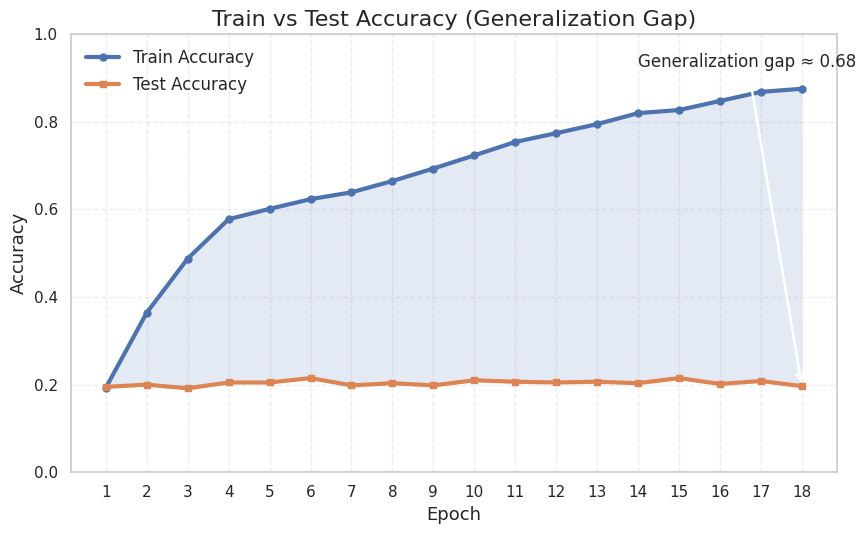

In [ ]:
# Cell 6 — Plot Train vs Test Accuracy (highlight gap)

# Purpose: Visualize the generalization gap that we just recorded. We shade the region between
# train and test accuracy and annotate the final-epoch gap to make the overfitting obvious.

import matplotlib.pyplot as plt
import numpy as np

epochs = np.arange(1, len(train_acc_hist)+1)

plt.figure(figsize=(9,5.5))
plt.plot(epochs, train_acc_hist, linewidth=3, marker="o", markersize=5, label="Train Accuracy")
plt.plot(epochs, test_acc_hist,  linewidth=3, marker="s", markersize=5, label="Test Accuracy")

# Shade the gap between the two curves to make the divergence easy to see
upper = np.maximum(train_acc_hist, test_acc_hist)
lower = np.minimum(train_acc_hist, test_acc_hist)
plt.fill_between(epochs, lower, upper, alpha=0.15)

# Annotate last-epoch generalization gap (simple and intuitive)
gap = train_acc_hist[-1] - test_acc_hist[-1]
plt.annotate(f"Generalization gap ≈ {gap:.2f}",
             xy=(epochs[-1], test_acc_hist[-1]),
             xytext=(epochs[-1]-4, min(1.0, train_acc_hist[-1]+0.05)),
             arrowprops=dict(arrowstyle="->", lw=1.8), fontsize=12)

plt.title("Train vs Test Accuracy (Generalization Gap)", fontsize=16)
plt.xlabel("Epoch", fontsize=13); plt.ylabel("Accuracy", fontsize=13)
plt.xticks(epochs)
plt.ylim(0, 1.0)
plt.grid(True, linestyle="--", alpha=0.35)
plt.legend(frameon=False, fontsize=12)
plt.tight_layout()
plt.savefig("gap_accuracy.png", dpi=200, bbox_inches="tight", transparent=True)
plt.show()

# Design choices
# Shading the gap + annotation makes the story clear at a glance.
# We keep the y-axis [0,1] since it’s a probability/accuracy.
#
# Alternatives:
# Add smoothing if curves are noisy; plot moving averages.
#
# Summary of this cell
# The plot shows train accuracy rising while test accuracy stays low → strong overfitting signal.
#
# Logic flow up to this cell
# We turned the numeric logs (Cell 5) into a visual that justifies why MIAs work well here.
#
# Next step (coming in Cell 7)
# Plot the corresponding train vs test *loss* curves to complete the picture.

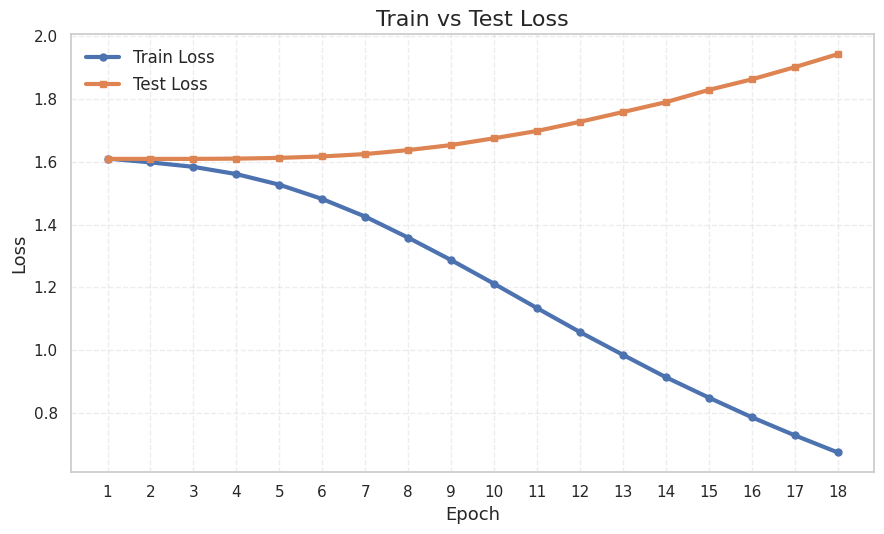

In [ ]:
# Cell 7 — Plot Train vs Test Loss

# Purpose: Loss curves complement accuracy. Even if accuracy looks flat, loss often keeps
# decreasing on train while staying high on test — another clear sign of memorization.

plt.figure(figsize=(9,5.5))
plt.plot(epochs, train_loss_hist, linewidth=3, marker="o", markersize=5, label="Train Loss")
plt.plot(epochs, test_loss_hist,  linewidth=3, marker="s", markersize=5, label="Test Loss")

plt.title("Train vs Test Loss", fontsize=16)
plt.xlabel("Epoch", fontsize=13); plt.ylabel("Loss", fontsize=13)
plt.xticks(epochs)
plt.grid(True, linestyle="--", alpha=0.35)
plt.legend(frameon=False, fontsize=12)
plt.tight_layout()
plt.savefig("gap_loss.png", dpi=200, bbox_inches="tight", transparent=True)
plt.show()

# Design choices
# - Same styling as the accuracy plot to keep visuals consistent.
# - No shaded area here; the two lines already show divergence clearly.
# Alternatives:
# - Semi-log y-axis if the loss spans a large range.
#
# Summary of this cell
# Train loss keeps dropping; test loss remains high → consistent with heavy overfitting.
#
# Logic flow up to this cell
# Accuracy + loss together paint a consistent picture of memorization in the target model.
#
# Next step (coming in Cell 8)
# Zoom in on the *attack* side again: plot the Threshold MIA ROC with emphasis on low FPR.

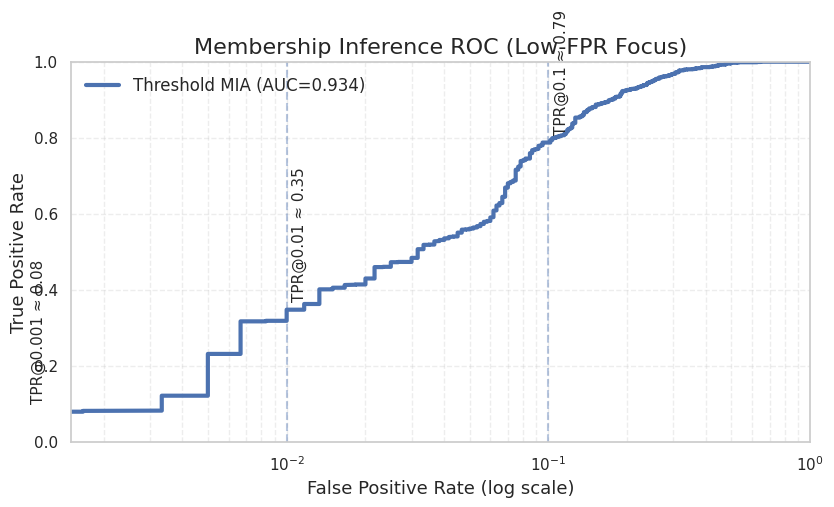

In [ ]:
# Cell 8 — Plot Threshold MIA ROC with Low-FPR Focus

# Purpose: Show how well the simple Threshold MIA (score = −loss) works on our overfit MLP.
# We emphasize the low-FPR region (10%, 1%, 0.1%), which is the realistic operating point
# discussed in the LiRA paper and privacy evaluations.

plt.figure(figsize=(8.5,5.2))
plt.plot(fpr_mia, tpr_mia, linewidth=3, label=f"Threshold MIA (AUC={auc_mia:.3f})")

# Add vertical reference lines at 1e-1, 1e-2, 1e-3 and annotate TPR there
for x in [1e-1, 1e-2, 1e-3]:
    plt.axvline(x, linestyle="--", alpha=0.4)
    tpr_val = tpr_at_fpr(fpr_mia, tpr_mia, x)   # this helper was defined in Cell 4
    plt.text(x*1.05, min(0.98, tpr_val+0.03), f"TPR@{x:g} ≈ {tpr_val:.2f}", rotation=90, fontsize=11)

plt.xscale("log")  # log-scale x-axis highlights behavior in the tiny-FPR region
# Guard lower x-limit so we don’t hit 0 on log scale
plt.xlim(max(1e-4, np.min(fpr_mia[fpr_mia > 0])*0.9), 1.0)
plt.ylim(0.0, 1.0)
plt.title("Membership Inference ROC (Low-FPR Focus)", fontsize=16)
plt.xlabel("False Positive Rate (log scale)", fontsize=13)
plt.ylabel("True Positive Rate", fontsize=13)
plt.grid(True, which="both", linestyle="--", alpha=0.35)
plt.legend(frameon=False, fontsize=12)
plt.tight_layout()
plt.savefig("roc_low_fpr.png", dpi=220, bbox_inches="tight", transparent=True)
plt.show()

# Design choices
# Focusing on low FPR gives a more realistic privacy view than just overall AUC.
# Annotating TPR@{0.1, 0.01, 0.001} mirrors how LiRA reports results.
#
# Alternatives:
# Add PR curves; or plot LiRA vs Threshold on the same figure (as done earlier).
#
# Summary of this cell
# We visualized how the basic Threshold MIA performs when the model is clearly overfitting.
# Strong leakage at low FPR confirms our earlier intuition from the learning curves.
#
# Logic flow up to this cell
# We connected training dynamics (Cells 5–7) to attack strength (this cell). Overfitting → leakage.